# Apllication of Scasat to Cusanovich data

This is the python notebook that uses __S__ingle-__c__ell __A__TAC-seq __A__nalysis __T__ool (Scasat) to process single cell ATAC-seq data from [_Cusanovich et. al._](http://science.sciencemag.org/content/348/6237/910) which is publicly available. In this anlaysis we only used the human data from this public data.

__Prerequisites:__

In order to use Scasat, you have to have the following tools installed in the machine where you are running Scasat
1. [samtools](http://www.htslib.org)
2. [bedtools](http://bedtools.readthedocs.io/en/latest/)
3. [macs2](https://github.com/taoliu/MACS)

If you are using jupyter from anaconda installation then you can install the tools with the following command
* samtools: conda install -c bioconda samtools
* bedtools: conda install -c bioconda bedtools 
* macs2: conda install -c bioconda macs2 (please note that macs2 only runs on python2.7 so you have to create a python2.7 environment if you are using python3

This jupyter notebook introduces __S__ingle-__c__ell __A__TAC-seq __A__nalysis __T__ool (Scasat) to deconvolute three cell types from a complex cell mixture. Scasat analyses single cell ATAC-seq data to identify regulatory regions that separates cells from a complex population. This notebook is the tool mentioned in [___Murtuza Baker et. al.___]()

### Import python packages

We import the python packages.

In [1]:
import subprocess, os, csv, signal, rpy2
import numpy as np
import readline
import rpy2.robjects
import matplotlib.pyplot as plt
import csv
from operator import itemgetter
%matplotlib inline

This code toggles between showing/hiding the codes. The outputs and the discussions would always be visible.

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



rpy2 package provides a simple and robust access to `R` from within `Python`. The following cells loads the package to run `R` code within `Python` notebook. To write and execute `R` code we will use the magic command `%%R` at the top of the cell. 

In [2]:
%load_ext rpy2.ipython

## Python Functions

Below we define the python functions for Scasat. One of the advantage of Scasat is the use of both python and R programming language. We use python for file processing and R for doing the data analysis.

In [3]:
def formatSummitBed(summitFile, fileToSave):
#fileToSave = 'location_toSave/AllFiles_Filtered_summits_shifted.bed' 
#peakFile = 'location_PeakFile/AllFiles_Filtered_summits.bed'

    with open(summitFile,'r') as f:
        peaks=[x.strip().split('\t') for x in f]
    for i in range(len(peaks)):
        peaks[i][1] = str(int(peaks[i][1]) - 250)
        peaks[i][2] = str(int(peaks[i][2]) + 250)

    peaks.sort(key=lambda x: float(x[4]), reverse=True)

    with open(fileToSave, "w") as f:
        writer = csv.writer(f,delimiter='\t')
        writer.writerows(peaks)

`formatSummitBed()`: 
> This functions formats the summit file by adding 500 bp distance from the summit position.

Arguments:
> `summitFile` : The name of the summit file. This has to be the file that is generated from the aggreagated `BAM` file<br>
> `fileToSave`: The name of the file where the save the peak file with the 500 bp peaks.

Value:
> File with 500 bp peaks.

In [4]:
def create_chunks(l, n):
    # For item i in a range that is a length of l,
    for i in range(0, len(l), n):
        # Create an index range for l of n items:
        yield l[i:i+n]

`create_chunks()`:
> Divides items in `l` into chunks with size `n`.

Arguements:
> `l`: Array of elements. <br>
> `n`: Number of elements in each chunk .

Value:
> Returns arrays with `n` elements

In [5]:
def getMergedBamSerial(BAMFolder, BAMFilePattern):
    
    import pandas as pd    
        
    mergeFiles = ''
    for root, folder, files in os.walk(BAMFolder):
            files = [os.path.join(root, f) for f in files if (f.endswith(BAMFilePattern))]
    
    #print(files)
    BamFileList = list(create_chunks(files,100))
    
    fileIndex = 0
    for bamFiles in BamFileList:
        mergeFiles = ''
        for f in bamFiles:
            mergeFiles = mergeFiles +  f + ' '
        mergeCommand = 'samtools merge ' + BAMFolder + str(fileIndex) + '_part_merged_nodup.bam' + ' ' + mergeFiles 
        fileIndex = fileIndex + 1
        #print(mergeCommand)
        subprocess.call(mergeCommand, shell=True)   
    
    mergeFiles = ''
    for root, folder, files in os.walk(BAMFolder):
            files = [os.path.join(root, f) for f in files if (f.endswith('_part_merged_nodup.bam'))]
            for f in files:
               mergeFiles = mergeFiles +  f + ' '

        
    mergeCommand = 'samtools merge ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' + mergeFiles    
    subprocess.call(mergeCommand, shell=True)     
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam'
    subprocess.call(indexMergeCmd, shell=True)
    
    cleanCommand = 'samtools view -b ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' \
                    + 'chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14' \
                    + ' chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX  > ' \
                    + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned.bam'
    subprocess.call(cleanCommand, shell=True)            
    
    sortMergeCmd = 'samtools sort -o ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam' \
                    + ' ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned.bam'        
    subprocess.call(sortMergeCmd, shell=True)
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam'
    subprocess.call(indexMergeCmd, shell=True) 

`getMergedBamSerial()`:
> First divides the number of BAM files into number of chunks. Each chunk would consist of 100 BAM files (these can be adjusted). Files in each chunk is merged to create partly merged BAM files. These partly merged BAM files are then merged to create `AllFiles_Filtered_Merged_nodup.bam` file. This file is then sorted and indexed. This function should be used when the number of BAM files exceeds the threshold of number of files that can be simultaneously opened in a system (`ulimit -Hn`).

Arguements:
> `BAMFolder`: Location of the folder where all the BAM files for each of the single-cells are. <br>
> `BAMFilePattern` : The end pattern of the `BAM` files to be merged.

Value:
> The merged `BAM` file `AllFiles_Filtered_Merged_nodup_sorted.bam`. 

In [6]:
def getMergedBam(BAMFolder, BAMFilePattern):
    
    import pandas as pd
    
        
    mergeFiles = ''
    for root, folder, files in os.walk(BAMFolder):
            files = [os.path.join(root, f) for f in files if (f.endswith(BAMFilePattern))]
            for f in files:
                mergeFiles = mergeFiles +  f + ' '
    
        
    mergeCommand = 'samtools merge ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' + mergeFiles    
    subprocess.call(mergeCommand, shell=True)   
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam'
    subprocess.call(indexMergeCmd, shell=True)
    
    cleanCommand = 'samtools view -b ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup.bam' + ' ' \
                    + 'chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14' \
                    + ' chr15 chr16 chr17 chr18 chr19 chr20 chr21 chr22 chrX  > ' \
                    + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned.bam'
    subprocess.call(cleanCommand, shell=True)            
    
    sortMergeCmd = 'samtools sort -o ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam' \
                    + ' ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned.bam'        
    subprocess.call(sortMergeCmd, shell=True)
    
    indexMergeCmd = 'samtools index ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam'
    subprocess.call(indexMergeCmd, shell=True) 

`getMergedBam()`:
> merges all the individual `BAM` files for each of the cells and creates `AllFiles_Filtered_Merged_nodup.bam` file. This file is then sorted and indexed.

Arguements:
> `BAMFolder`: Location of the folder where all the BAM files for each of the single-cells are. <br>
> `BAMFilePattern` : The end pattern of the `BAM` files to be merged.

Value:
> The merged `BAM` file `AllFiles_Filtered_Merged_nodup_sorted.bam`. 

In [7]:
def getAggregatedPeak(BAMFolder, BAMFilePattern):
    
    # getMergedBamSerial() should be called if number of BAM files exceeds the limit set by ulimit -Hn
    getMergedBamSerial(BAMFolder, BAMFilePattern)
    
    # This function should be used if the numbe of BAM files are does not exceed the limit set by ulimit -Hn
    #getMergedBam(BAMFolder, BAMFilePattern)
    
    MergedMacs2Cmd = '/home/mqbsxsm2/anaconda3/envs/python2/bin/macs2 callpeak -t ' + BAMFolder + 'AllFiles_Filtered_Merged_nodup_cleaned_sorted.bam' +' -n ' \
                    + BAMFolder + 'AllFiles_Filtered' +' -q 0.2 -g hs -f BAMPE --nomodel --nolambda \
                    -B --call-summits --keep-dup all; source deactivate'
    subprocess.run(MergedMacs2Cmd, shell=True)
    
    narrowPeakFile = BAMFolder + 'AllFiles_Filtered_peaks.narrowPeak'
    mergedPeakFile = BAMFolder + 'mergedPeaks.bed'
    tmpPeakFile = BAMFolder + 'tmpPeak.txt'
    
    
    with open(narrowPeakFile,'r') as f:
        peaks=[x.strip().split('\t') for x in f]
    peaks.sort(key=lambda x: float(x[8]), reverse=True)
    
    
    peaksToWrite = list()
    for i in range(len(peaks)):
        peaksToWrite.insert(i, peaks[i][0:4])
        peaksToWrite[i].append(peaks[i][8])      
    
    
    with open(mergedPeakFile, "w") as f:
        writer = csv.writer(f,delimiter='\t')        
        writer.writerows(peaksToWrite)        
        
    sortCmd = 'sort -k1,1 -k2,2n ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)
    
    bedToolsCmd ='bedtools merge -i ' + tmpPeakFile + ' -c 5 -o last > ' + mergedPeakFile
    subprocess.call(bedToolsCmd, shell=True)
    
    sortCmd = 'sort -nrk4 ' + mergedPeakFile + ' > ' + tmpPeakFile  
    subprocess.call(sortCmd, shell=True)    
    
    copyCmd = 'cat ' + tmpPeakFile + ' > ' + mergedPeakFile
    subprocess.call(copyCmd, shell=True)    

`getAggregatedPeak()`:
> This function calls `MACS2` on the aggregated `BAM` file and generates the peaks. If the user is following the merging BAM option then this is the function they need to call. Then the `getMergedBam()` is called within this function

Arguements:
> `BAMFolder`: Location of the folder where all the BAM files for each of the single-cells are. <br>
> `BAMFilePattern` : The end pattern of the `BAM` files to be merged.

Value:
> Peak files from MACS2 call.

------------------
## R functions

### Loading R packages (if not available it will install it before loading)

Pleae note that inorder to install `GenomicFeatures` the mysql library has to be alreay installed. If it is not available in your system the use the following command to install it

`sudo apt-get install libdbd-mysql libmysqlclient-devthe`

In [9]:
%%R
if (!require("pacman")) install.packages("pacman")
pacman::p_load(ggplot2, GenomicFeatures, ComplexHeatmap, Rtsne, prabclus, GGally, rtracklayer, corrplot, 
               cluster, EnsDb.Hsapiens.v75, ChIPpeakAnno, org.Hs.eg.db, rGREAT, marge, tidyverse, tibble)

### R functions for the Scasat

Now I define all the R functions. These functions will be used for most of the downstream analysis. A short explanation of each function along with its input and output are also given below of each function. 

In [10]:
%%R
peakAccessibility <- function(mergedPeakFile, peakFolder, peakFilePattern, outputFolder, outputPeakFileName){
    if(length(list.files(path=peakFolder, pattern = paste0(peakFilePattern,'.bed'), full.names=TRUE))>0){
        files = list.files(path=peakFolder, pattern = paste0(peakFilePattern,'.bed'), full.names=TRUE)
        unlink(files)
    }
    formatingToBed(peakFolder, peakFilePattern, outputFolder)
    peakFilePattern = paste0(peakFilePattern,'.bed')
    query = import(mergedPeakFile)
    queryDF <- data.frame(query)
    #queryDF <- queryDF[order(queryDF$name, decreasing=TRUE),]    
    
    totalOverlap <- data.frame(seqnames = queryDF$seqnames, start = queryDF$start, end = queryDF$end)    
    files <- list.files(path=peakFolder, pattern = peakFilePattern, full.names=TRUE)
    cellName <- list.files(path=peakFolder, pattern = peakFilePattern)
    for (i in 1:length(files)){
        subject = import(files[i])
        hits = findOverlaps(query, subject)
        hitsDF <- data.frame(hits)
        cellName[i] <- gsub(peakFilePattern, '', cellName[i])
        totalOverlap[hitsDF$queryHits, cellName[i]] <- 1
        totalOverlap[-hitsDF$queryHits, cellName[i]] <- 0
    }
    outputFile = paste0(outputFolder,outputPeakFileName)
    write.table(totalOverlap, outputFile, row.names=FALSE)    
}    


`peakAccesibility()`:
> This function calculates the accessible peaks for each of the cells. It looks at each of the peaks listed in _Aggregated-Peak_ table and tries to find out whether there is any overlap between these peaks and the peaks of each cell. If there is then it puts a 1 agains that cells for that peak. Otherwise it puts 0. Calling these function for each of the cell completes the _Aggregated-Peak_ for which rows represnt all the peaks and the column represents cells.

Arguements:
> `mergedPeakFile`: This is the name and location of `mergedPeaks.bed` file that were generated while calling `mergePeaks()` python function.<br>
> `peakFolder`: This is the location of the folder where all the peaks for each of the single-cells are located. <br>
> `peakFilePattern` : The end pattern of the `peak` files of each single cells found in the `peakFolder`. Currently the only two accepted patterns are `_peaks.narrowPeak` and `_summits_shifted.bed` <br>
> `outputFolder`: Folder where all the outputs will be saved
> `outputPeakFileName`: Name of the file where the peak accessibility table, _Aggregated-Peak_ would be saved. This file will contain all the accessibility information for all the cells.


Value:
> Peak accessibile table saved according to the name set in `outputPeakFileName`. The table will have the results in 1 or 0 expression peak opening or closing respectively.

In [11]:
%%R
formatingToBed <- function(peakFolder, peakFilePattern, outputFolder){
    files <- list.files(path=peakFolder, pattern = peakFilePattern, full.names=TRUE)
    for (i in 1:length(files)){
        narrowPeak <- read.csv(files[i], header=FALSE, sep='\t')
        write.table(narrowPeak[,1:4], paste0(files[i],'.bed'), 
                    row.names=FALSE, sep='\t', col.names=FALSE, quote=FALSE)
    }
}

`formatingToBed()`:
> This function formats the bed file suitable for processing by ScAsAT. It adds a `.bed` extension at the end.

Arguements:
> `mergedPeakFile`: This is the name and location of `mergedPeaks.bed` file that were generated while calling `mergePeaks()` python function.<br>
> `peakFolder`: This is the location of the folder where all the peaks for each of the single-cells are located. <br>
> `peakFilePattern` : The end pattern of the `peak` files of each single cells found in the `peakFolder`. Currently the only two accepted patterns are `_peaks.narrowPeak` and `_summits_shifted.bed` <br>
> `outputFolder`: Folder where all the outputs will be saved

Value:
> Formats the bed files with adding a `.bed` extesion.

In [12]:
%%R
calcEntropy <- function(data){
	freqs <- table(data)/sum(table(data))
	return(-sum(freqs * log(freqs)))
}

`calcEntropy()`:
> Calcuates entropy is calculated as
$$\sum_{i=1}^c -p_i log_2 p_i$$


`Usage`:
> `calcEntropy(count_data)`

Arguements:
> `count_data`: The peak information converted into binary. 

Value:
> Returns entropy of the count data.

In [13]:
%%R
getDiffAccessInformationGain <- function(cdBinary, groups=NULL){

    if (length(levels(groups)) != 2) {
        stop(paste("ERROR: wrong number of levels in the grouping factor (", 
            paste(levels(groups), collapse = " "), "), but must be two.", 
            sep = ""))
    }
    if (is.null(groups)){
        stop("ERROR: groups factor is not provided")
    }
    
    
    SingleCell.Group1.CellNames <- names(groups[groups==levels(groups)[1]])
    SingleCell.Group2.CellNames <- names(groups[groups==levels(groups)[2]])
    
    SingleCell.Group1.Binary <- cdBinary[,SingleCell.Group1.CellNames]
    SingleCell.Group2.Binary <- cdBinary[,SingleCell.Group2.CellNames]
    
    CellType <- data.frame(CellType=gsub('_.*','',names(groups)))
    
         
    SingleCell.Group1VsGroup2 <- cbind(SingleCell.Group1.Binary,SingleCell.Group2.Binary)
    SingleCell.Group1VsGroup2 <- t(SingleCell.Group1VsGroup2)
    #SingleCell.Group1VsGroup2 <- cbind(SingleCell.Group1VsGroup2,CellType)   

    
    dataDim = (dim(SingleCell.Group1VsGroup2)[2])
    #dataDim = 5
    
    information.gain = vector(mode="numeric", length=(ncol(SingleCell.Group1VsGroup2)-1))
    SingleCell.Group1VsGroup2.res <- data.frame(Chr = cdBinary[1:dataDim,1],
                                           Start = cdBinary[1:dataDim,2],
                                           end = cdBinary[1:dataDim,3])        
    
    
    for(i in 1:dataDim)
    {
        jointData = cbind(SingleCell.Group1VsGroup2[,i], CellType)
        
        gain <- calcEntropy(jointData[,2]) - 
                (sum(table(jointData)[c(1,3)])/length(jointData[,2]))*calcEntropy(jointData[jointData[,1]==0,]) - 
                (sum(table(jointData)[c(2,4)])/length(jointData[,2]))*calcEntropy(jointData[jointData[,1]==1,])
        SingleCell.Group1VsGroup2.res$information.gain[i] <- gain        
    }
    
        
    SingleCell.Group1.rawAvg <- rowSums(SingleCell.Group1.Binary==1)/dim(SingleCell.Group1.Binary)[2]
    SingleCell.Group2.rawAvg <- rowSums(SingleCell.Group2.Binary==1)/dim(SingleCell.Group2.Binary)[2]
    
    SingleCell.Group1VsGroup2.res$rawMeanGroup1 <- SingleCell.Group1.rawAvg
    SingleCell.Group1VsGroup2.res$rawMeanGroup2 <- SingleCell.Group2.rawAvg
    SingleCell.Group1VsGroup2.res$log2FoldChange <- log2(SingleCell.Group1VsGroup2.res$rawMeanGroup1/
                                                       SingleCell.Group1VsGroup2.res$rawMeanGroup2)
    

    #write.csv(SingleCell.Group1VsGroup2[order(SingleCell.Group1VsGroup2$information.gain, decreasing=TRUE),], 
    #          paste0(levels(groups)[1],'_vs_',levels(groups)[2],'InformationGain.csv'), row.names=FALSE)
    
    SingleCell.Group1VsGroup2.res <- SingleCell.Group1VsGroup2.res[!is.nan(SingleCell.Group1VsGroup2.res$information.gain) &
                                                                  !is.na(SingleCell.Group1VsGroup2.res$information.gain),]
    
    return(SingleCell.Group1VsGroup2.res)    
}

`getDiffAccessInformationGain()`:
> Caculates differential accessibility between two groups of cells using entropy and information gain. For each peak the accessibility is encoded as a binary variable. For each peak we calculate the "Information gain" by having the peak divided into two groups of cells for which we are trying to find out the differential accessibilty. The Information gain is calculated as

$$ 
 Gain(P, P_{G_1}, P_{G_2}) = Entropy(P) - \sum_{v \epsilon\{G_1,G_2 \}} \frac{|P_v|}{|P|}Entropy(P_v)
$$

>where Entropy is calculated as
$$\sum_{i=1}^c -p_i log_2 p_i$$

> The peaks are then sorted based on the informatin gain and the user can choose the cutoff value for selecting the DA peaks. A suggested value for this would be values < 0.01


`Usage`:
> `getDiffAccessLogsitic(count_data, groups)`

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>

>`groups` : groups into which each cell belong to.

Value:
> Returns a table with the peaks along with Information gain.

In [14]:
%%R
getDiffAccess <- function(cdBinary, groups=NULL){

    if (length(levels(groups)) != 2) {
        stop(paste("ERROR: wrong number of levels in the grouping factor (", 
            paste(levels(groups), collapse = " "), "), but must be two.", 
            sep = ""))
    }
    if (is.null(groups)){
        stop("ERROR: groups factor is not provided")
    }
    
    
    SingleCell.Group1.CellNames <- names(groups[groups==levels(groups)[1]])
    SingleCell.Group2.CellNames <- names(groups[groups==levels(groups)[2]])
    
    SingleCell.Group1.Binary <- cdBinary[,SingleCell.Group1.CellNames]
    SingleCell.Group2.Binary <- cdBinary[,SingleCell.Group2.CellNames]

    SingleCell.Group1.ZeroCount <- rowSums(SingleCell.Group1.Binary==0)
    SingleCell.Group2.ZeroCount <- rowSums(SingleCell.Group2.Binary==0)
    SingleCell.Group1.OneCount <- rowSums(SingleCell.Group1.Binary==1)
    SingleCell.Group2.OneCount <- rowSums(SingleCell.Group2.Binary==1)
    
    SingleCell.Group1VsGroup2 <- data.frame(Chr = cdBinary[,1],
                                           Start = cdBinary[,2],
                                           end = cdBinary[,3])

    SingleCell.Group1VsGroup2$group1OneCounts <- SingleCell.Group1.OneCount
    SingleCell.Group1VsGroup2$group2OneCounts <- SingleCell.Group2.OneCount
    SingleCell.Group1VsGroup2$log2Fold <- log2((SingleCell.Group1.OneCount+1)/dim(SingleCell.Group1.Binary)[2]) - 
                                            log2(((SingleCell.Group2.OneCount+1)/dim(SingleCell.Group2.Binary)[2]))
    pvalue = vector(mode="numeric", length=length(SingleCell.Group2.OneCount))
    nGenes <- nrow(SingleCell.Group1.Binary)
    
    
    for(i in 1:length(SingleCell.Group2.OneCount))
    {
        contingencyTable <- matrix(c(SingleCell.Group1.ZeroCount[i], SingleCell.Group2.ZeroCount[i],
                                     SingleCell.Group1.OneCount[i], SingleCell.Group2.OneCount[i]), ncol=2)
        SingleCell.Group1VsGroup2$pvalue[i] <- fisher.test(contingencyTable)$p.value        
    }
    
    # Bonferroni correction
    SingleCell.Group1VsGroup2$p_adjust <- p.adjust(SingleCell.Group1VsGroup2$pvalue, method="bonferroni")

    write.csv(SingleCell.Group1VsGroup2[order(SingleCell.Group1VsGroup2$p_adjust, decreasing=FALSE),], 
              paste0(levels(groups)[1],'_vs_',levels(groups)[2],'.csv'), row.names=FALSE)
    
    return(SingleCell.Group1VsGroup2)    
}

`getDiffAccess()`:
> Caculates differential accessibility between two groups of cells. For each peak it creates a contingency table with number of 0's and 1's for the two groups. <br>

>|               	| Group-1 	| Group-2 	|
|---------------	|---------	|---------	|
| Number of 0's 	|         	|         	|
| Number of 1's 	|         	|         	| 
<br>
It then runs Fisher exact test to calculate the p-values. These p-values are then corrected for multiple testing with Bonferroni correction. Finally the function returns a table with the peaks, their count of 1's in each group, the p-value and the q-value (corrected p-value).

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>

Value:
> Returns a table with the peaks, their count of 1's in each group, the p-value and the q-value (corrected p-value).

In [15]:
%%R
getPeakVsPrecision <- function(peakA, peakB,start=100,stepSize=100){
    
    if (colnames(peakA)[1] != 'chr' | colnames(peakA)[2] != 'start' | colnames(peakA)[3] != 'end') {
        stop(paste("ERROR: Column name should have 'Chr' 'Start' 'End'"))
    }

    dimToRun <- min(dim(peakA)[1],dim(peakB)[1])
    if(dim(peakB)[1]>dimToRun){
        peakB <- peakB[1:dimToRun,]
    }
    GenomicRangeObjA <- makeGRangesFromDataFrame(peakA,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("chr"),
                         start.field="start",
                         end.field=c("end"),
                         starts.in.df.are.0based=FALSE)
    j=1
    Recall <- vector(mode="numeric", length=0)
    Precision <- vector(mode="numeric", length=0)
    for(i in seq(100,(dimToRun-stepSize),stepSize)){
           GenomicRangeObjB <- makeGRangesFromDataFrame(peakB[1:i,],
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("chr"),
                         start.field="start",
                         end.field=c("end"),
                         starts.in.df.are.0based=FALSE)

           write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
	   write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
           bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
           intersectRes = system(bedToolsCmd, intern=TRUE)
           
           FP = dim(peakB[1:i,])[1] - length(intersectRes)
           TP = length(intersectRes)
           
           GenomicRangeObjB <- makeGRangesFromDataFrame(peakB[(i+1):dim(peakB)[1],],
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("Chr"),
                         start.field="Start",
                         end.field=c("End"),
                         starts.in.df.are.0based=FALSE)
                         
           write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
	   write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
           bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
           intersectRes = system(bedToolsCmd, intern=TRUE)

           TN = dim(peakB[(i+1):dim(peakB)[1],]) - length(intersectRes)
           FN = length(intersectRes)
           Recall[j] = 100*(TP/(TP + FN))
           Precision[j] = 100*(TP / (TP + FP))
           j = j +1
           
   
    }
    df<-data.frame(x=Recall,y=Precision)
    p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    
    p <- p + ggtitle("Recall vs Precision") + theme(plot.title = element_text(size = 16, face = "bold"))
    p <- p + geom_point(size = 2)
    p <- p + xlab("Recall%") 
    p <- p + ylab("Precision%")+
	theme_light(base_size=15) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
    print(p)
    
    GenomicRangeObjB <- makeGRangesFromDataFrame(peakB,
                         keep.extra.columns=FALSE,
                         ignore.strand=TRUE,
                         seqinfo=NULL,
                         seqnames.field=c("Chr"),
                         start.field="Start",
                         end.field=c("End"),
                         starts.in.df.are.0based=FALSE)
                         
     write.table(GenomicRangeObjA, 'tmpPeakA.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
     write.table(GenomicRangeObjB, 'tmpPeakB.bed', sep='\t', row.names=FALSE, quote=FALSE, col.names=FALSE)
     bedToolsCmd = 'bedtools intersect -a tmpPeakB.bed -b tmpPeakA.bed -u'
     intersectRes = system(bedToolsCmd, intern=TRUE)
   
   return(intersectRes) 
}

`getPeakVsPrecision()`:
> This function is used to see how many peaks from the Bulk data the single-cell have been able to capture. For that we calculate the Peak and the Precision of the single-cell data against its Bulk counterpart and then plot it. The way these two values are calculated are

$$
Recall = 100  \frac{TP}{TP + FN}
$$
$$
Precision = 100  \frac{TP}{TP + FP}
$$
> where <br>
> TP = True Positive <br>
> TN = True Negative <br>
> FP = False Positive <br>
> FN = False Negative <br>

`Usage`:
> `getPeakVsPrecision(peakA, peakB,start,stepSize)`

Arguements:
> `peakA`: Peak of the BULK data <br>
> `peakB`: Single-cell Peak <br>
> `start`: Number of peaks to start with the calculation, default is `100`. <br>
> `stepSize`: Size of the increase steps

Value:
> Plots Recall vs. Precision and returns a summary

In [16]:
%%R
getJaccardDist <- function(cdBinary){
        
    if(colnames(cdBinary[,2:3])[1] == 'start' && colnames(cdBinary[,2:3])[2] == 'end'){
        SingleCell.Binary <- cdBinary[,4:(dim(cdBinary)[2])]
    }
    else
        SingleCell.Binary <- cdBinary
    
    
    SingleCell.Binary.Jaccard <- jaccard(as.matrix(SingleCell.Binary))
    
    return(SingleCell.Binary.Jaccard)
}

`getJaccardDist()`:
> This function calculates the jaccard distance between each of the cells. Jaccard distance calculates the ratio between the differences of the sizes of the union and intersection against the size of the union. The equation for calculating this distance is <br><br>$$d_J(A,B)=\frac{|A \cup B| - |A \cap B|}{|A \cup B|}$$

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. 


Value:
> Jaccard distance between each of the cell.

In [17]:
%%R
plotMDS <- function(cdBinary, k, groups=NULL, cellName, ret.val=FALSE, text.label=FALSE, 
                    title="", cordinates=c(1,2)){
    cbPallete <- c("navyblue", "grey32", "red", "green", "saddlebrown","purple3","steelblue2","black","darkgreen","hotpink","gold","darkorange","gray72")
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=k)

 
    if(is.null(groups)){
        df<-data.frame(x=fit$points[,cordinates[1]],y=fit$points[,cordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard))
        p <- ggplot(df, aes_string(x="x",y ="y"))+ scale_colour_hue(l=40)
    }
    else{
        df<-data.frame(x=fit$points[,cordinates[1]],y=fit$points[,cordinates[2]], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
        p <- ggplot(df, aes_string(x="x",y ="y", color="Batch"))
            #scale_colour_hue(l=40)
            #scale_fill_manual(values = getPalette(15))
    }

    
    p <- p + ggtitle(title) + theme(plot.title = element_text(size = 20, face = "bold"))
    p <- p + geom_point(size = 1.20)
    p <- p + xlab(paste0("Coordinate ",cordinates[1])) 
    p <- p + ylab(paste0("Coordinate ",cordinates[2]))+
	theme_light(base_size=12) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))

       
    if(text.label==TRUE)
        p <- p + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)

    #p <- p + theme(axis.title = element_text(size = 14), axis.text = element_text(size = 14),
    #legend.text = element_text(size = 14), legend.title = element_text(size = 14))
    p <- p + scale_color_manual(values=cbPallete)
    print(p)
    
    if(ret.val == TRUE)
        return(fit)
}

`plotMDS()`:
> This function calculates the Multidimensional Scaling (MDS) and plots the cells based on Jaccard distance to visualize the level of similarity between the cells.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`k`: The maximum dimension of the space which the data are to be represented in; must be in {1, 2, ..., n-1}. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`cellName`: If `text.label` is set to `TRUE` then you have to supply `cellName`.
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.


Value:
> Calculates the MDS and plots the cells based on their MDS dimension. It returns the MDS values if `ret.val` is set to TRUE.

In [18]:
%%R
plotPCAJaccard <- function(cdBinary, groups=NULL, ret.val=FALSE , cellName, text.label=FALSE, title){
    
   
    if(missing(ret.val)){
        ret.val = FALSE
    }
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)
    percentVar <- pcaPRComp$sdev^2/sum(pcaPRComp$sdev^2)
 
    if(is.null(groups)){
        df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy])
        p1<-ggplot(df, aes_string(x="PCX",y ="PCY"))        
    }
    else{
        df<-data.frame(PCX=pcaPRComp$x[,PCx],PCY=pcaPRComp$x[,PCy], groups=groups)
        p1<-ggplot(df, aes_string(x="PCX",y ="PCY", color="groups"))             
    }          
    if(missing(title))
        p1<-p1+ggtitle("PCA with Jacard Matrix")
    else
        p1<-p1+ggtitle(title)
        
    p1<-p1+geom_point(size = 3)
    p1<-p1+xlab(paste("PC",PCx,": ", round(percentVar[PCx] * 100), "% variance"))
    p1<-p1+ylab(paste("PC",PCy,": ", round(percentVar[PCy] * 100), "% variance"))
    if(text.label == TRUE){
        p1<-p1+geom_text(data=df,aes(label=cellName),
                       alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45, color="black")
    }
    
    p1<-p1 +
    theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())

    if(length(levels(groups)) < 12)
        p1 <- p1 + scale_colour_brewer(palette="Set1")
    
    print(p1)
        
    if(ret.val == TRUE)
        return(pcaPRComp)
}

`plotPCAJaccard()`:
> This function calculates the Principle Component Analysis (PCA) and plots the cells based on Jaccard distance in a reduced dimension to visualize how the cells cluster together.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates PCA and plots the cells in reduced dimension. If`ret.val` is set to TRUE it returns the PCA components along with standard deviations. 

In [19]:
%%R
plotMultiplePCAJaccard <- function(cdBinary, nPCAToDisplay, groups=NULL, ret.val=FALSE , text.label=FALSE, title=""){
    
    if(missing(nPCAToDisplay)){
    	stop("ERROR: Number of PCA's \"nPCAToDisplay\" to display is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)

    nmax = nPCAToDisplay
    plotTitle = paste0('Plotting first ',nmax,' PCAs')
    
    txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
    pca_var = pcaPRComp$sdev ^ 2
    pca_var_percent <- 100 * pca_var / sum(pca_var)
    pca_var_percent_first10 <- NA * pca_var
    pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

    pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),
                          round(pca_var_percent_first10,1))
    rownames(pca_var_out) <- colnames(pcaPRComp$x)
    colnames(pca_var_out) <- c("PC_Var","PC_Var_percent",txt1)


    if(is.null(groups)){
        df <- as.data.frame(pcaPRComp$x)
        p <- ggpairs(df, columns=1:nPCAToDisplay, upper=list(continuous="points"), 
             title=plotTitle,              
             columnLabels = as.character(paste0(colnames(df[,1:nPCAToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nPCAToDisplay], '% variance')))+
    	     theme_light(base_size=15)+     
             theme(plot.title = element_text(hjust = 0.5))        
    }
    else{
        df <- as.data.frame(pcaPRComp$x)
        df$Cell=groups        
        p <- ggpairs(df, columns=1:nPCAToDisplay, upper=list(continuous="points"), 
             title=plotTitle, 
             mapping = aes_string(color="Cell"),
             legend = c(1,nPCAToDisplay),
             columnLabels = as.character(paste0(colnames(df[,1:nPCAToDisplay]), ' : ', 
                                                pca_var_out$PC_Var_percent[1:nPCAToDisplay], '% variance')))+
             theme_light(base_size=15)+     
             theme(plot.title = element_text(hjust = 0.5))
    }          
    
    print(p)
}

`plotMultiplePCAJaccard()`:
> This function calculates the Principle Component Analysis (PCA) based on Jacard distance and plots the first `n` components of the PCA.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to display. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates PCA and plots the cells in first `n` components. If`ret.val` is set to TRUE it returns the PCA components along with standard deviations. 

In [20]:
%%R
plotVarExplained <- function(cdBinary, nPCAToDisplay, groups=NULL, ret.val=FALSE , text.label=FALSE, title=""){

    if(missing(nPCAToDisplay)){
    	stop("ERROR: Number of PCA's \"nPCAToDisplay\" to display is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    FinalPCAData <- t(SingleCell.Binary.Jaccard)
    PCx=1
    PCy=2
    pcaPRComp <- prcomp(FinalPCAData)

    nmax = nPCAToDisplay
    plotTitle = paste0('Plotting first ',nmax,' PCAs')
    
    txt1 <- paste("Percent_PC_Var_onfirst",nmax,"PCs",sep="")
    pca_var = pcaPRComp$sdev ^ 2
    pca_var_percent <- 100 * pca_var / sum(pca_var)
    pca_var_percent_first10 <- NA * pca_var
    pca_var_percent_first10[1:nmax] <- 100 * pca_var[1:nmax] / sum(pca_var[1:nmax])

    pca_var_out <- data.frame(round(pca_var,3),round(pca_var_percent,1),round(pca_var_percent_first10,1))
    rownames(pca_var_out) <- colnames(pcaPRComp$x)
    colnames(pca_var_out) <- c("PC_Var","PC_Var_percent","PC_Var_n_percent")


    p <- ggplot(pca_var_out[1:nmax,]) + scale_colour_hue(l=40) 
    p <- p + geom_line(aes(x=c(1:nmax), y = PC_Var_percent, color="PC_Var_percent"), size=1.5)+
         geom_point(aes(x=c(1:nmax), y = PC_Var_percent, color="PC_Var_percent"), size = 2)+
         geom_line(aes(x=c(1:nmax), y = PC_Var_n_percent, color="PC_Var_n_percent"), size=1.5)+
         geom_point(aes(x=c(1:nmax), y = PC_Var_n_percent, color="PC_Var_n_percent"), size = 2)+
         ggtitle("Total variance by the PCAs considered")+
         xlab(paste("PC1 to PC10"))+
         ylab(paste("% of Variance"))+     
         theme_light(base_size=15)+     
         theme(plot.title = element_text(hjust = 0.5),
              panel.border     = element_blank())+
         scale_x_continuous(breaks=c(1:nmax))+
         scale_colour_brewer(palette="Set1")
         
   print(p)
}

`plotVarExplained()`:
> This function calculates the percent of variance explained by the PCAs and plots it.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to display. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates the percent of variance explained by the PCAs and the plots thsoe percentage. 

In [21]:
%%R
plot_tSNE <- function(cdBinary, nDimToUSE, groups=NULL, cellName, perplexity_division, ret.val=FALSE , text.label=FALSE, title=""){

    cbPallete <- c("navyblue", "grey32", "red", "green", "saddlebrown","purple3","steelblue2","black","darkgreen","hotpink","gold","darkorange","gray72")
    if(missing(nDimToUSE)){
    	stop("ERROR: Number of PCA's \"nDimToUSE\" to use is missing")
    }
    if(missing(ret.val)){
        ret.val = FALSE
    }
    
    if(text.label==TRUE & missing(cellName)){
        stop("ERROR: Please give cellName")
    }
    
    if(missing(perplexity_division)){
        stop("ERROR: Please enter the number with which you want to divide the dimension of your data for perplexity setting")
    }
        
    
    #SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    #FinalPCAData <- t(SingleCell.Binary.Jaccard)
    
    SingleCell.Binary.Jaccard <- getJaccardDist(cdBinary)
    fit <- cmdscale(as.dist(SingleCell.Binary.Jaccard),eig=TRUE, k=nDimToUSE)

    #pcaPRComp <- prcomp(FinalPCAData)

    
    #rtsne_pca_out <- Rtsne(as.matrix(pcaPRComp$x[,1:nPCAToUSE]), perplexity = dim(pcaPRComp$x)[1]/perplexity_division, check_duplicates = FALSE)
    rtsne_pca_out <- Rtsne(as.matrix(fit$points[,1:nDimToUSE]), perplexity = perplexity_division, 
                           check_duplicates = FALSE, pca=FALSE, theta=0.05, max_iter=3000)
    
    if(is.null(groups)){
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2])
        p1 <- ggplot(df, aes_string(x="X",y ="Y"))
    }
    else{
        if(ret.val==TRUE)
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups, cellName=cellName)
        else
            df<-data.frame(X=rtsne_pca_out$Y[,1],Y=rtsne_pca_out$Y[,2], Cell=colnames(SingleCell.Binary.Jaccard), Batch=groups)
        p1 <- ggplot(df, aes_string(x="X",y ="Y", color="Batch"))
    }
    

    p1<-p1 + ggtitle("t-SNE plot")
    p1<-p1 + geom_point(size = 1.00) 
    p1<-p1 + xlab(paste("t-SNE 1"))
    p1<-p1 + ylab("t-SNE 2")+
        theme_classic(base_size=12) +
        theme(strip.background = element_blank(),
              panel.border     = element_blank(),
              plot.title = element_text(hjust = 0.5))
    if(length(levels(groups)) < 12)
        p1 <- p1 + scale_colour_brewer(palette="Set1")
    if(text.label==TRUE)
        p1<-p1 + geom_text(data=df,aes(label=cellName),alpha=0.5,size=4, vjust=1,hjust=0.5,angle=45)
    p1 <- p1 + scale_colour_manual(values=cbPallete)
    print(p1)
    return(df)
}

`plot_tSNE()`:
> Caculates the t-distributed stochastic neighbor embedding (t-SNE) which is a non-linear dimensionality reduction technique particualrly suitable for embedding high-dimensional data into a space of two or three dimensions. This function then plots the lower dimensional representation of the cells in a 2-D scatter plot.

Arguements:
> `cdBinary`: The peak information converted into binary. Ideally this would be file that set in the `outputPeakFileName`. `cdBinary` would be used to calculate the Jaccard distance which would then be used as d matrix in MDS calculation<br>
`nPCAToDisplay` : Number of PCAs to be used to calcualte the t-SNE values. <br>
`groups`: If the cells can be organized into different groups (for eg. different batches), then they are passed as groups making them factor variable.<br>
`ret.val`: Need to set this TRUE for the function to return the MDS values <br>
`text.label`: Need to set this TRUE if label of each of the cells are to be printed in the plot.<br>
`title`: Sets the title of the plot.


Value:
> Calculates and plots the t-SNE representation of the cells. 

In [22]:
%%R
clean.count.peaks <- function(cd, min.cell.peaks.obs = 10, min.peaks.cell = 50){
    cdFilt <- cd[,1:3]
    cdCells <- cd[,4:dim(cd)[2]]
    valid.cell.ix <- which(colSums(cdCells) >= min.peaks.cell)
    cdFilt <- cbind(cdFilt,cdCells[,valid.cell.ix])
    cdFilt <- cdFilt[rowSums(cdFilt[,4:dim(cdFilt)[2]]) >=min.cell.peaks.obs ,]
    cdFiltTemp <- cdFilt[,1:3]
    cdCells <- cdFilt[,4:dim(cdFilt)[2]]
    valid.cell.ix <- which(colSums(cdCells) > 0)
    cdFilt <- cbind(cdFiltTemp,cdCells[,valid.cell.ix])
    return(cdFilt)
}

`clean.count.peaks()`:
> This function filter peaks and cells based on peak and cell requirements.

Usage:
> `clean.count.peaks(cd, min.cell.peaks.obs = 10, min.peaks.cell = 50)`

Arguements:
> `cd`: A binay matrix with the peak accessiblity of all the single-cells. The row would reprsent each of the peaks unique name and the columns would be each cell. Each entry in the matrix is 0/1 representing either the peak is close/open for that cell. <br>
> `min.cell.peaks.obs`: Minimum number of cells that a peak has to be observed in order for that peak to be a valid peak. <br>
> `min.peaks.cell` : Minimum number of peaks that a cell needs to have in order for that cell to be called a valid cell. <br>

Value:
> A matrix with valid accessible peaks.

In [23]:
%%R
multiplot <- function(..., plotList=NULL, File, cols=1, layout=NULL) {

  # Adopted from Cookbook for R
  library(grid)

  plots <- c(list(...), plotList)

  numPlots = length(plots)

  if (is.null(layout)) {
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

--------------

# Analysis
Below we start the analysis with Cusanovich data. 

Reading the peak files

In [24]:
%%R
peakFile <- 'mouse_atlas.csv'
cd <- read.csv(peakFile, sep='\t', header=TRUE)

In [25]:
%%R
dim(cd)

[1] 436206   3000


In [27]:
%%R
df <- data.frame(matrix(unlist(strsplit(rownames(cd),'_')), nrow=dim(cd)[1], byrow=T))
colnames(df)<- c('seqnames','start','end')

In [29]:
%%R
cd <- cbind(df,cd)

Read annotation file

In [31]:
%%R
annot <- read.table('cell_metadata_sample.csv',sep='\t', header=TRUE)

## Filtering accessible peaks

Now we filter all the low quality cells and peaks.

As there are 436206 peaks we would consider a cell to be a valid cell if it has at least 436 peaks (at least 0.1% of the total peaks). Also a peak is valid peak to be valid if it is observed in at least 2% (60 cells) of the cells.

In [43]:
%%R
cdFilt <- clean.count.peaks(cd,min.peaks.cell = 436, min.cell.peaks.obs = 60)
print(dim(cd))
print(dim(cdFilt))
cdFiltTop <- cdFilt

[1] 436206   3003
[1] 50534  3003


In [44]:
%%R
write.csv(cdFiltTop, 'cdTop_Cusanovich_updated.csv', sep='\t')

In [32]:
%%R
Batches <- levels(as.factor(sub('-.*','',annot$cell_label)))
Batches

 [1] "Activated B cells"          "Alveolar macrophages"      
 [3] "Astrocytes"                 "B cells"                   
 [5] "Cardiomyocytes"             "Cerebellar granule cells"  
 [7] "Collecting duct"            "Collisions"                
 [9] "DCT/CD"                     "Dendritic cells"           
[11] "Distal convoluted tubule"   "Endothelial I (glomerular)"
[13] "Endothelial I cells"        "Endothelial II cells"      
[15] "Enterocytes"                "Erythroblasts"             
[17] "Ex. neurons CPN"            "Ex. neurons CThPN"         
[19] "Ex. neurons SCPN"           "Hematopoietic progenitors" 
[21] "Hepatocytes"                "Immature B cells"          
[23] "Inhibitory neurons"         "Loop of henle"             
[25] "Macrophages"                "Microglia"                 
[27] "Monocytes"                  "NK cells"                  
[29] "Oligodendrocytes"           "Podocytes"                 
[31] "Proximal tubule"            "Proximal tubule S3" 

In [51]:
%%R
table(annot$cell_label)


         Activated B cells       Alveolar macrophages 
                        14                         17 
                Astrocytes                    B cells 
                        60                        205 
            Cardiomyocytes   Cerebellar granule cells 
                       133                        171 
                        10                         35 
                    DCT/CD            Dendritic cells 
                        19                         33 
  Distal convoluted tubule Endothelial I (glomerular) 
                         6                         20 
       Endothelial I cells       Endothelial II cells 
                        41                        105 
               Enterocytes              Erythroblasts 
                       171                        104 
           Ex. neurons CPN          Ex. neurons CThPN 
                        69                         66 
          Ex. neurons SCPN  Hematopoietic progenitors 
         

In [33]:
%%R
table(annot$tissue)


      BoneMarrow       Cerebellum            Heart           Kidney 
             304               74              268              234 
  LargeIntestine            Liver             Lung PreFrontalCortex 
             259              234              373              234 
  SmallIntestine           Spleen           Testes           Thymus 
             139              136              100              292 
      WholeBrain 
             353 


In [34]:
%%R
cbPallete <- c("navyblue", "grey32", "red", "green", "saddlebrown","magenta4","steelblue2","black","darkgreen","hotpink","gold","orange","gray72")

In [35]:
%%R
cellNames <- colnames(cdFiltTop[,4:dim(cdFiltTop)[2]])
cellTypes <- annot$cell_label
cellTissue <- annot$tissue
#cellTypes <- as.factor(gsub('[0-9]','',colnames(cdFiltTumorTopSel[,4:dim(cdFiltTumorTopSel)[2]])))


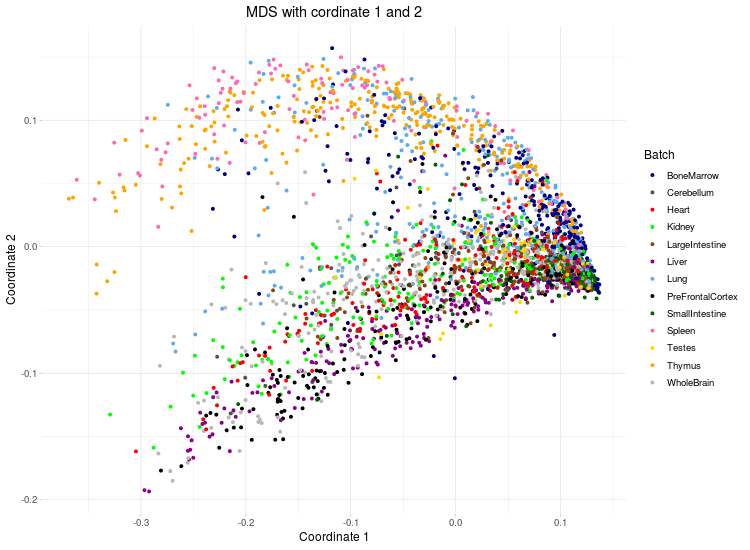

In [105]:
%%R -w 750 -h 550
#pdf('MDS_with_batch_effect.pdf')
MDSClust <- plotMDS(cdFiltTop, 4, groups=cellTissue, ret.val=TRUE, text.label=FALSE, title="MDS with cordinate 1 and 2")
#dev.off()

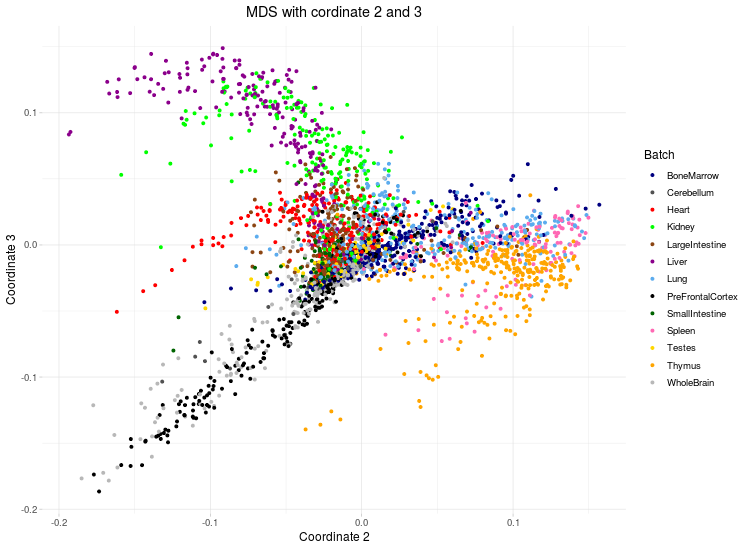

In [104]:
%%R -w 750 -h 550
MDSClust <- plotMDS(cdFiltTop, 4, groups=cellTissue, ret.val=TRUE, text.label=FALSE, cordinates=c(2,3), title="MDS with cordinate 2 and 3")

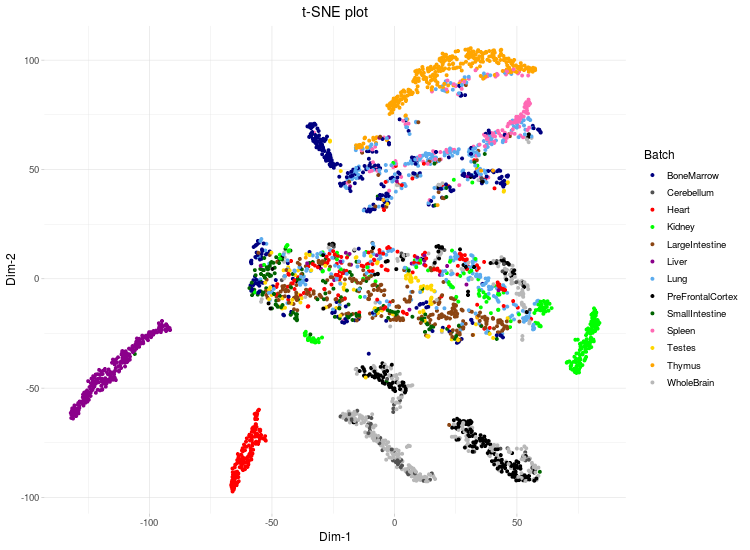

In [109]:
%%R -w 750 -h 550
set.seed(100)
#pdf('tSNE-All-Batch.pdf')
tsNE_out_2PCs <- plot_tSNE(cdFiltTop, 10, groups=cellTissue, perplexity=30, 
                              cellName=cellNames,ret.val=TRUE, text.label=F)

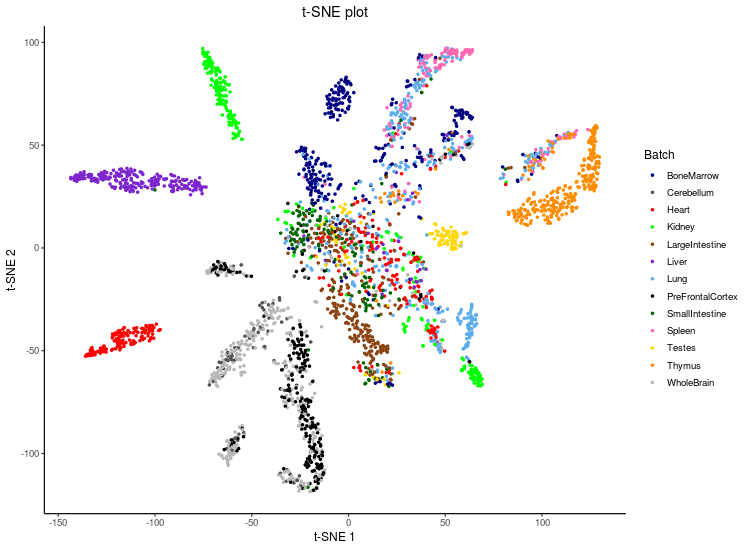

In [48]:
%%R -w 750 -h 550
set.seed(100)
#pdf('tSNE-All-Batch.pdf')
tsNE_out_2PCs <- plot_tSNE(cdFiltTop, 40, groups=cellTissue, perplexity=20, 
                              cellName=cellNames,ret.val=TRUE, text.label=F)

In [43]:
%%R -w 750 -h 550
set.seed(100)
pdf('tSNE-Cusanovich_sampled_cells_V3.pdf')
tsNE_out_2PCs <- plot_tSNE(cdFiltTop, 40, groups=cellTissue, perplexity=20, 
                              cellName=cellNames,ret.val=TRUE, text.label=F)

## Clustering
Now I would do clustering of the cells. I will use the `dynamicTreeCut` method for which I do not need to mention the number of clusters beforehand.

In [49]:
%%R
my.dist <- as.dist(getJaccardDist(cdFiltTop))

In [80]:
%%R
#chosen.exprs <- as.matrix(cdTmpIndex)
#my.dist <- dist(t(chosen.exprs), method="binary")
my.tree <- hclust(my.dist, method = "ward.D2")


library(dynamicTreeCut)
my.clusters <- unname(cutreeDynamic(my.tree, distM=as.matrix(my.dist), verbose=0))


levels(as.factor(my.clusters))

[1] "1" "2" "3" "4" "5" "6" "7"


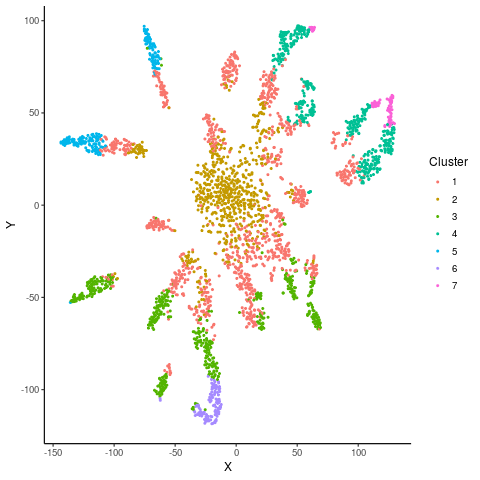

In [81]:
%%R
df<-data.frame(X=tsNE_out_2PCs$X,Y=tsNE_out_2PCs$Y,  
               Cluster = as.factor(my.clusters), 
               cellType = as.factor(cellTypes),
               cellTypesRepComb = as.factor(cellTissue))
 ggplot(df, aes_string(x="X",y ="Y", color="Cluster")) + geom_point(size=0.75) + theme_classic(base_size=12)

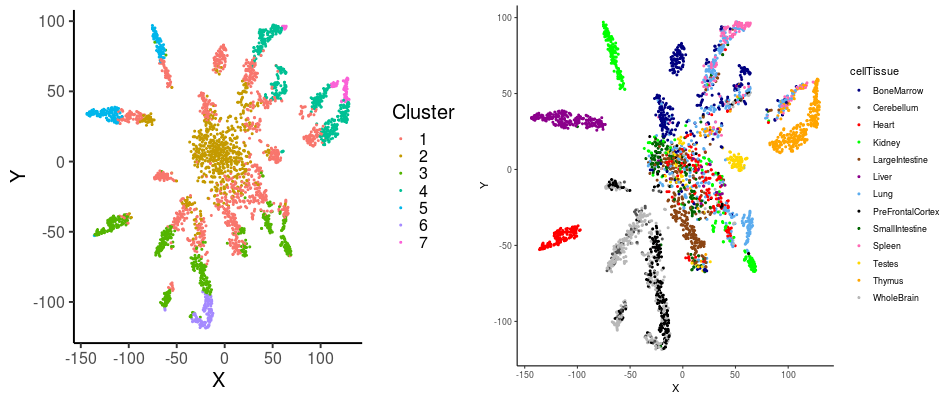

In [82]:
%%R -w 950 -h 400
df<-data.frame(X=tsNE_out_2PCs$X,Y=tsNE_out_2PCs$Y,  
               Cluster = as.factor(my.clusters), 
               cellTissue = as.factor(cellTissue))
p1 <- ggplot(df, aes_string(x="X",y ="Y", color="Cluster")) + geom_point(size=0.75) + theme_classic(base_size=20)
p2 <- ggplot(df, aes_string(x="X",y ="Y", color="cellTissue")) + geom_point(size=0.75) + theme_classic() + scale_color_manual(values=cbPallete)

multiplot(p1,p2,cols=2)

As mentioned in cusanovich et. al. clusters in their dataset appear in many tissues. This is what we observe in our results as well.

In [148]:
%%R
save.image('cusanovich.RData')